# generation.cnn

> Fill in a module description here

In [ ]:
from monitosed.data.core import *
from monitosed.models import *
from monitosed.losses import *

%load_ext autoreload
%autoreload 2

In [ ]:
import mat73
from fastcore.xtras import Path
import pandas as pd
import numpy as np

from tsai.all import *

# Prepare Data

In [ ]:
path = Path("../_data/foot1/Rest"); path.ls()

(#14) [Path('../_data/foot1/Rest/VR23_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR20_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR26_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR31_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR27_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR40_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR51_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR41_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR38_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR35_RestStim_data_clean.mat')...]

## Load data

In [ ]:
mats = load_mats(path)

  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_Reststim_data_clean.mat
Loading: VR23_RestStim_data_clean.mat
Loading: VR26_Reststim_data_clean.mat
Loading: VR27_Reststim_data_clean.mat
Loading: VR31_Reststim_data_clean.mat
Loading: VR35_RestStim_data_clean.mat
Loading: VR38_RestStim_data_clean.mat
Loading: VR40_RestStim_data_clean.mat
Loading: VR41_RestStim_data_clean.mat
Loading: VR51_RestStim_data_clean.mat
Loading: VR52_RestStim_data_clean.mat
Loading: VR57_Reststim_data_clean.mat
Loading: VR59_Reststim_data_clean.mat
Loading: VR60_Reststim_data_clean.mat


In [ ]:
#Optional
signal_len = 1500

## Get labels

The first idea is to perform forecasting, i.e. predict the future signal. To do so, we have to cut the measured signal into a past and the future we would like to predict.

/!\ the stimulus happens at 250

In [ ]:
trn_len = 1000
pred_len = signal_len-trn_len
valid_pct=0.2

## DataBlock

In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
data = np.concatenate([read_data(mat) for mat in mats])
data = data[:,:,:signal_len]
data.shape

(778, 173, 1500)

In [ ]:
x = torch.from_numpy(np.concatenate(data, axis=0))[:,:trn_len].unsqueeze(1)
y = torch.from_numpy(np.concatenate(data, axis=0))[:,trn_len:]
x.shape, y.shape

(torch.Size([134594, 1, 1000]), torch.Size([134594, 500]))

In [ ]:
splits = create_splits(mats)

In [ ]:
# For randperm
train_ix = int((1-valid_pct)*len(mats))
read_mats = [read_data(mat) for mat in mats]
rearranged_mats = [new_rearrange(mat) for mat in read_mats]
n_train_sample = np.concatenate(rearranged_mats[:train_ix]).shape[0]
randperm = torch.randperm(x.shape[0])
rand_splits = (np.array(randperm[:n_train_sample]), np.array(randperm[n_train_sample:]))

In [ ]:
splits[0].shape, splits[1].shape

((103454,), (31140,))

In [ ]:
#dblock = DataBlock(blocks=(TSTensorBlock, TSTensorBlock),
#                   getters=getters,
#                   splitter=IndexSplitter(splits[1]),
#                   item_tfms=None,
#                   batch_tfms=None)

In [ ]:
#source = itemify(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

In [ ]:
dls = get_ts_dls(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), splits=splits, bs=128)

In [ ]:
#dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=4)

KeyboardInterrupt: 

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 1000]), torch.Size([128, 500]))

[<matplotlib.lines.Line2D>]

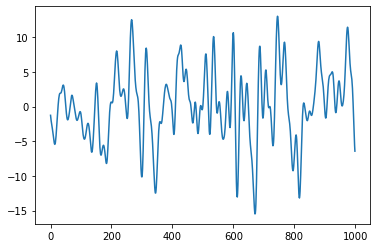

In [ ]:
plt.plot(xb[0][0].to('cpu').numpy())

In [ ]:
model = TimeSeriesModel(1, pred_len)
learn = Learner(dls, model, loss_func=CustomLoss(), metrics=[mae, rmse], wd=0.001, cbs=ShowGraph())

SuggestedLRs(valley=0.001737800776027143)

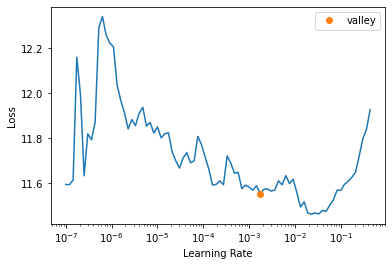

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,9.693105,7.056831,2.404412,3.421878,00:15
1,8.114635,7.393760,2.469032,3.509770,00:15
2,7.606911,7.418622,2.473575,3.516201,00:15
3,6.844526,7.436425,2.479528,3.520416,00:15
4,6.479427,7.425214,2.478462,3.517380,00:15
5,6.107447,7.504903,2.492799,3.537939,00:15
6,5.685992,7.499231,2.495255,3.535986,00:15
7,5.541937,7.450821,2.489485,3.523090,00:15
8,5.185974,7.479107,2.493871,3.530487,00:15
9,5.003172,7.503276,2.497432,3.536824,00:15


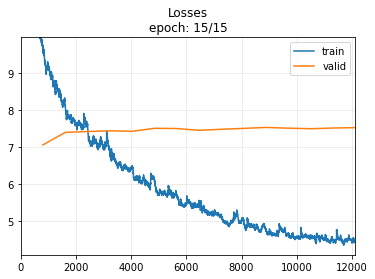

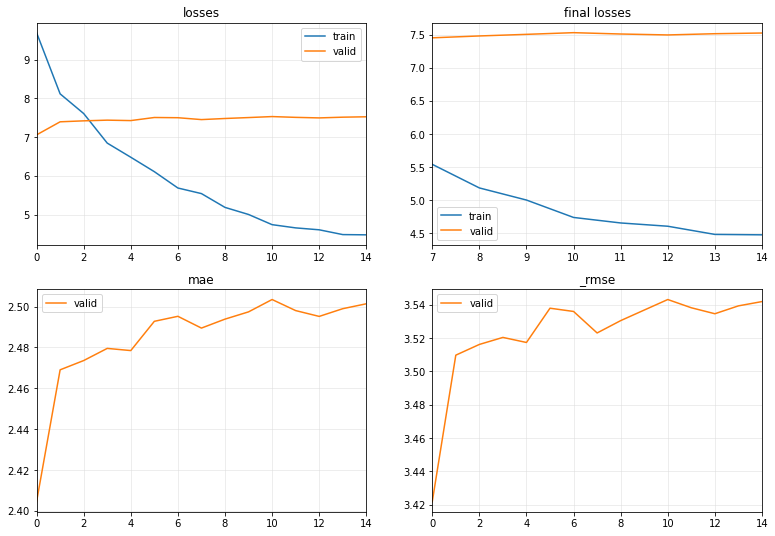

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-3)

In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

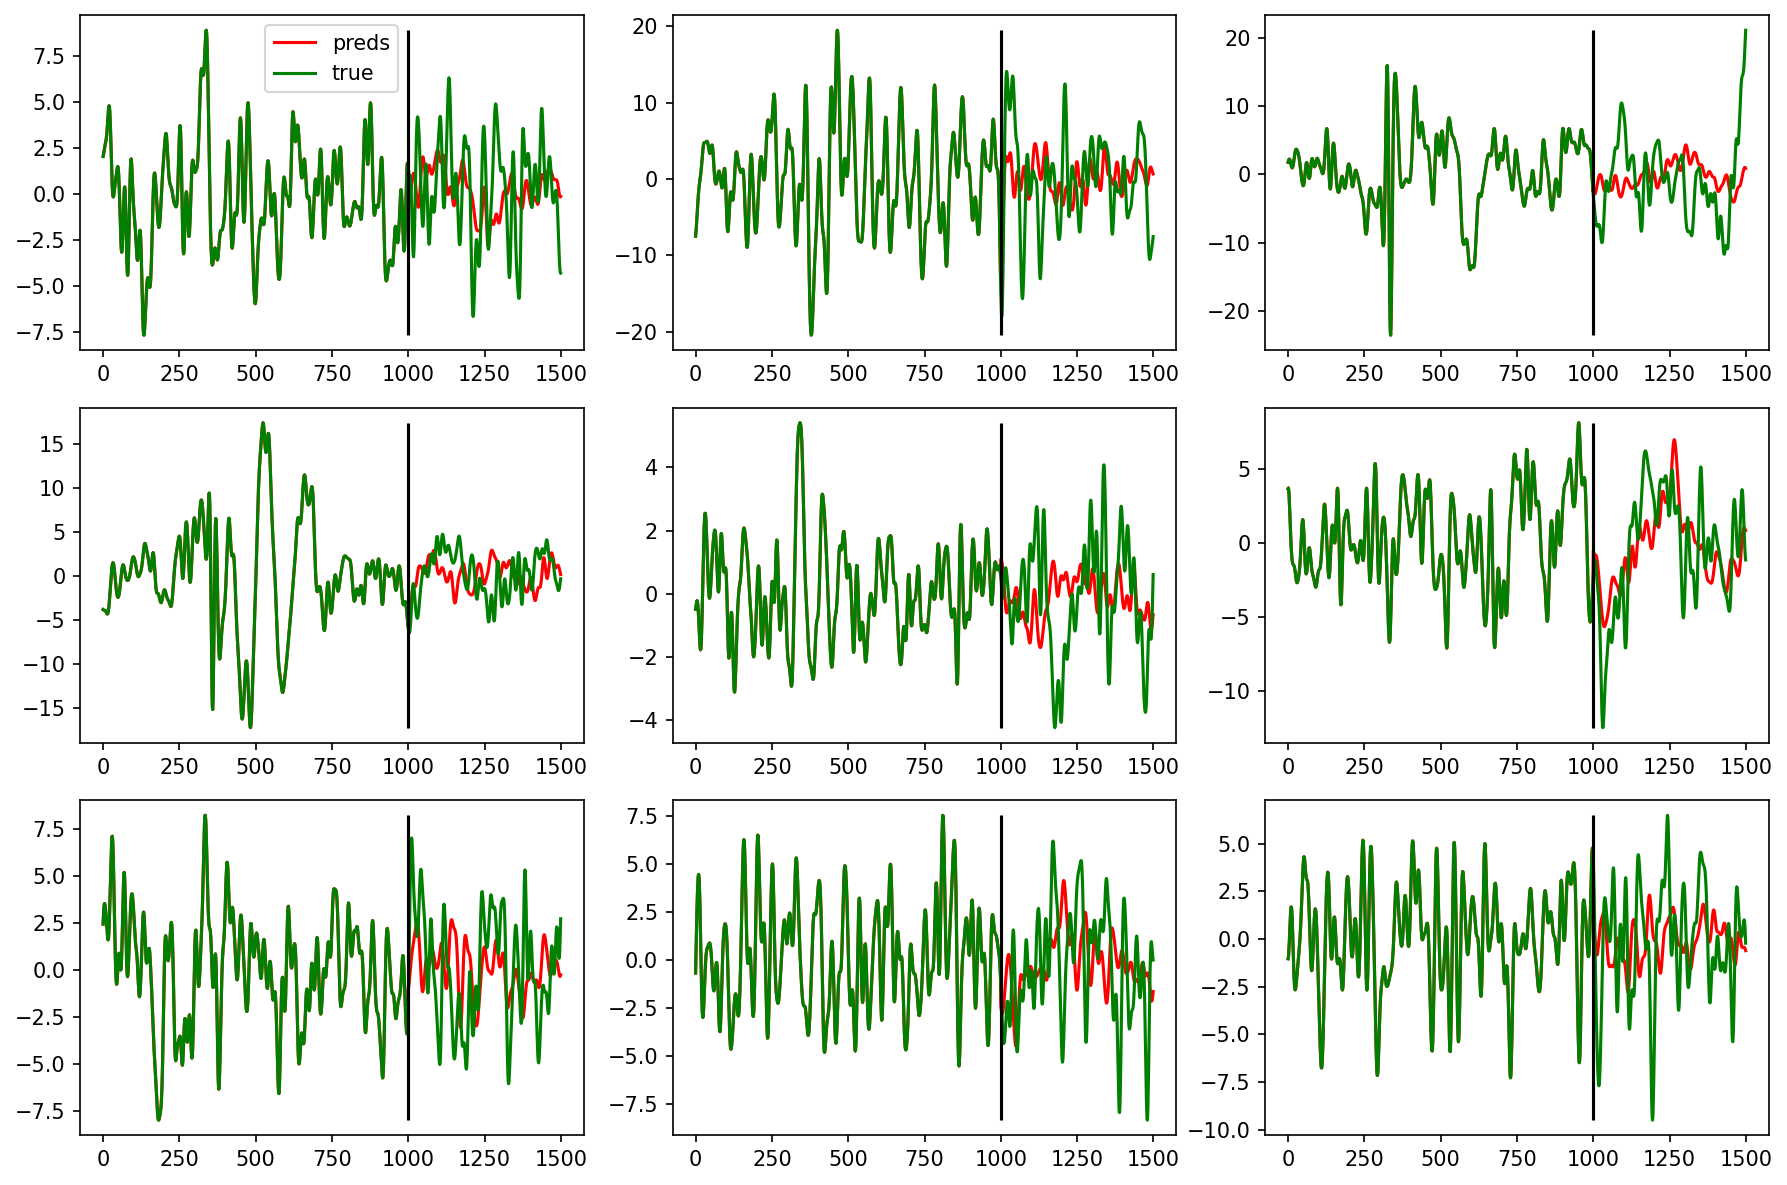

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,8), dpi=150)
for i, ax in enumerate(axes.flat):
    plot_idx = np.random.choice(np.arange(0, len(in_valid)))
    true = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), true_valid.numpy()[plot_idx,:].reshape(-1)])
    pred = np.concatenate([in_valid.numpy()[plot_idx,-1,:].reshape(-1), pred_valid[plot_idx,:].reshape(-1)])
    ax.plot(pred, color='red', label='preds')
    ax.plot(true, color='green', label='true')
    ax.vlines(trn_len-1, np.min(true), np.max(true), color='black')
    if i == 0: ax.legend()
fig.tight_layout();